In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os
import sys
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import ogb
import ast
from scipy import stats

In [83]:
import torch
from torch_geometric.data import Data, DataLoader

In [84]:
cwd = os.getcwd()
print(cwd)

/cluster/home/skyriakos/chemprop_run/git/notebooks


In [85]:
pd.set_option('display.max_rows', 100)

In [86]:
os.chdir('..')
import deepadr
from deepadr.dataset import *
from deepadr.utilities import *
from deepadr.run_workflow import *
from deepadr.chemfeatures import *
from deepadr.model_gnn import GCN as testGCN
os.chdir(cwd)

In [87]:
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

In [88]:
# from tdc.single_pred import Tox
# from tdc.multi_pred import DDI
from tdc.multi_pred import DrugSyn
# data = DrugSyn(name = 'OncoPolyPharmacology')



In [89]:
rawdata_dir = '../data/raw/'
processed_dir = '../data/processed/'
up_dir = '..'

In [90]:
report_available_cuda_devices()

number of GPUs available: 8
cuda:0, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:1, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:2, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:3, name:GeForce GTX 1080 Ti
total memory available: 10.91650390625 GB
total memory allocated on device: 0.0 GB
max memory allocated on device: 0.0 GB
total memory cached on device: 0.0 GB
max memory cached  on device: 0.0 GB

cuda:4, name:GeForce GTX 1080 Ti
total memory av

In [91]:
n_gpu = torch.cuda.device_count()
n_gpu

8

In [92]:
fdtype = torch.float32

In [93]:
print("torch:", torch.__version__)
print("CUDA:", torch.version.cuda)

torch: 1.9.1
CUDA: 11.1


### Preparing dataset 

In [94]:
df_synergxdb_zloewe = pd.read_csv('../data/synergxdb/API/df_synergxdb_filter_zloewe_sel.csv')
df_synergxdb_zloewe

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cosmic_ID,Drug1,Drug2,Dataset
0,TH588,BI-2536,A-549,1,905949,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
1,TH588,BI-2536,HCC38,1,749717,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
2,TH588,BI-2536,HCT 116,1,905936,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
3,TH588,BI-2536,MDA-MB-436,1,1240172,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
4,TH588,BI-2536,MDA-MB-231,1,905960,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
...,...,...,...,...,...,...,...,...
195077,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
195078,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
195079,Veliparib,Ridaforolimus,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,MERCK
195080,Veliparib,SN 38 Lactone,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,MERCK


In [95]:
df_rma_landm = pd.read_csv('../data/synergxdb/RMA/df_rma_landm.tsv', sep="\t")
df_rma_landm

,Unnamed: 0,GENE_SYMBOLS,GENE_title,DATA.906826,DATA.687983,DATA.910927,DATA.1240138,DATA.1240139,DATA.906792,DATA.910688,...,DATA.753584,DATA.907044,DATA.998184,DATA.908145,DATA.1659787,DATA.1298157,DATA.1480372,DATA.1298533,DATA.930299,DATA.905954.1
0,0,TSPAN6,tetraspanin 6 [Source:HGNC Symbol;Acc:11858],7.632023,7.548671,8.712338,7.797142,7.729268,7.074533,3.285198,...,7.105637,3.236503,3.038892,8.373223,6.932178,8.441628,8.422922,8.089255,3.112333,7.153127
1,3,SCYL3,SCY1-like 3 (S. cerevisiae) [Source:HGNC Symbo...,3.614794,4.066887,3.956230,4.063701,4.341500,4.270903,5.968168,...,3.696835,4.624013,4.348524,3.858121,3.947561,4.425849,3.550390,4.443337,4.266828,4.100493
2,19,BAD,BCL2-associated agonist of cell death [Source:...,7.458409,7.479327,7.419672,7.731137,6.998981,6.550210,6.354063,...,7.147962,6.478426,6.919537,6.801096,7.153122,7.234464,7.525257,6.066356,8.185968,4.967268
3,20,LAP3,leucine aminopeptidase 3 [Source:HGNC Symbol;A...,6.453926,6.742826,5.655691,5.259367,4.611395,6.930777,8.560707,...,5.383810,8.591164,6.208059,6.715130,6.530806,5.759933,7.810126,7.182077,5.663629,6.539451
4,28,SNX11,sorting nexin 11 [Source:HGNC Symbol;Acc:14975],4.767457,5.246301,4.645800,4.558836,5.456692,5.099542,7.574348,...,4.755084,6.761799,5.034195,4.958603,4.629068,4.982202,5.037259,4.611973,4.800284,4.967207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,17398,RDH14,retinol dehydrogenase 14 (all-trans/9-cis/11-c...,8.030599,8.679559,9.036084,9.321920,9.533746,8.910534,9.267845,...,8.508849,9.176905,8.813209,8.596516,8.850828,8.852085,8.791652,9.017896,9.679394,8.945712
968,17400,MIF,macrophage migration inhibitory factor (glycos...,11.893872,11.841300,12.272137,12.000410,11.867211,12.621575,11.825283,...,12.286071,12.572595,12.254136,12.588238,12.366026,12.153612,12.265099,11.919307,12.762295,12.985613
969,17444,PRAF2,"PRA1 domain family, member 2 [Source:HGNC Symb...",5.060852,6.515567,4.815762,4.544863,6.071288,4.777850,3.455981,...,5.314914,2.943601,4.723601,5.769965,5.070665,3.443244,3.293080,2.978125,5.125786,4.404205
970,17575,LYN,v-yes-1 Yamaguchi sarcoma viral related oncoge...,5.892532,4.580184,6.482469,7.094195,7.932918,7.333405,10.455397,...,4.914232,9.453552,3.218797,4.073831,6.355383,8.348965,7.579339,4.456322,5.857488,3.013612


In [96]:
# TDC Tox
DSdataset_name = 'SynergxZloewe' #'DrugComb'
# OncoPolyPharmacology is the MERCK dataset


#fname_suffix = ds_config["fname_suffix"]
similarity_types = ['chem']
kernel_option = 'sqeuclidean'
data_fname = 'data_v1'
# interact_matfname = ds_config["interact_matfname"]
# exp_iden = 'simtypeall'
# ddi_interaction_labels_pth = ds_config["ddi_interaction_labels_pth"]

# up_dir, processed_dir, DSdataset_name, data_fname

In [97]:
targetdata_dir = create_directory(os.path.join(processed_dir, DSdataset_name, data_fname))
targetdata_dir_raw = create_directory(os.path.join(targetdata_dir, "raw"))
targetdata_dir_processed = create_directory(os.path.join(targetdata_dir, "processed"))
# ReaderWriter.dump_data(dpartitions, os.path.join(targetdata_dir, 'data_partitions.pkl'))

path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr
path_current_dir /cluster/home/skyriakos/chemprop_run/git/deepadr


In [98]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/SynergxZloewe/data_v1'

In [99]:
# data = DDI(name = DSdataset_name).get_data(format = 'df')
# data = DrugSyn(name = DSdataset_name).get_data(format = 'df')


In [100]:
# from tdc.utils import get_label_map
# get_label_map(name = 'DrugBank', task = 'DDI')


In [101]:
# data = Tox(name = DSdataset_name).get_data(format = 'df')
# smiles, labels = data['Drug'], data['Y']

In [102]:
data = df_synergxdb_zloewe
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cosmic_ID,Drug1,Drug2,Dataset
0,TH588,BI-2536,A-549,1,905949,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
1,TH588,BI-2536,HCC38,1,749717,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
2,TH588,BI-2536,HCT 116,1,905936,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
3,TH588,BI-2536,MDA-MB-436,1,1240172,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
4,TH588,BI-2536,MDA-MB-231,1,905960,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
...,...,...,...,...,...,...,...,...
195077,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
195078,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
195079,Veliparib,Ridaforolimus,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,MERCK
195080,Veliparib,SN 38 Lactone,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,MERCK


In [103]:
data

,Drug1_ID,Drug2_ID,Cell_Line_ID,Y,Cosmic_ID,Drug1,Drug2,Dataset
0,TH588,BI-2536,A-549,1,905949,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
1,TH588,BI-2536,HCC38,1,749717,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
2,TH588,BI-2536,HCT 116,1,905936,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
3,TH588,BI-2536,MDA-MB-436,1,1240172,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
4,TH588,BI-2536,MDA-MB-231,1,905960,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,VISAGE
...,...,...,...,...,...,...,...,...
195077,Veliparib,Dinaciclib,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2N=C(C=C(N2N=C1)NCC3=C[N+](=CC=C3)[O-])N...,MERCK
195078,Veliparib,Geldanamycin,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CC(C(C(C=C(C(C(C=CC=C(C(=O)NC2=CC(=O)C(=C(C...,MERCK
195079,Veliparib,Ridaforolimus,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CC1CCC2CC(C(=CC=CC=CC(CC(C(=O)C(C(C(=CC(C(=O)C...,MERCK
195080,Veliparib,SN 38 Lactone,RPMI-7951,0,910903,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,MERCK


In [104]:
# datashort = data[['Drug1_ID', 'Drug2_ID', 'Y']]
# datashort.Y = 1
# datashort = datashort[~datashort.duplicated()]
# datashort

In [105]:
uniq_data = ddi_dataframe_to_unique_drugs(data)
uniq_data

,Drug_ID,Drug
0,TH588,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N
1,Ixabepilone,CC1CCCC2(C(O2)CC(NC(=O)CC(C(C(=O)C(C1O)C)(C)C)...
2,Mitomycin,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N
3,Crizotinib,CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N...
4,Tretinoin,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C
...,...,...
825,Trifluoperazine,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)...
826,Trifluridine,C1C(C(OC1N2C=C(C(=O)NC2=O)C(F)(F)F)CO)O
827,WZ4002,CN1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)OC4=CC...
828,PNU-74654,CC1=CC=C(O1)C=NNC(=O)C2=CC=CC=C2OC3=CC=CC=C3


In [106]:
uniq_data['Mol'] = [smiles_to_mol(smiles) for smiles in uniq_data.Drug]

In [107]:
uniq_mol = uniq_data[~uniq_data.Mol.isnull()]
# uniq_mol['Data'] = [mol_to_graph_data_obj_simple(mol) for mol in uniq_mol.Mol]
uniq_mol['DataOGB'] = [smiles_to_graph_data_obj_ogb(smiles) for smiles in uniq_mol.Drug]
uniq_mol = uniq_mol.set_index("Drug_ID")
uniq_mol

,Drug,Mol,DataOGB
Drug_ID,,,
TH588,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,<rdkit.Chem.rdchem.Mol object at 0x2b3c73926b20>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Ixabepilone,CC1CCCC2(C(O2)CC(NC(=O)CC(C(C(=O)C(C1O)C)(C)C)...,<rdkit.Chem.rdchem.Mol object at 0x2b3c739110a0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Mitomycin,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,<rdkit.Chem.rdchem.Mol object at 0x2b3c73911940>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Crizotinib,CC(C1=C(C=CC(=C1Cl)F)Cl)OC2=C(N=CC(=C2)C3=CN(N...,<rdkit.Chem.rdchem.Mol object at 0x2b3c73911be0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Tretinoin,CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C,<rdkit.Chem.rdchem.Mol object at 0x2b3c739118e0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
...,...,...,...
Trifluoperazine,CN1CCN(CC1)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C(F)...,<rdkit.Chem.rdchem.Mol object at 0x2b3c77d4a820>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
Trifluridine,C1C(C(OC1N2C=C(C(=O)NC2=O)C(F)(F)F)CO)O,<rdkit.Chem.rdchem.Mol object at 0x2b3c77d4a7c0>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."
WZ4002,CN1CCN(CC1)C2=CC(=C(C=C2)NC3=NC=C(C(=N3)OC4=CC...,<rdkit.Chem.rdchem.Mol object at 0x2b3c77d4a760>,"[(edge_index, [tensor([ 0, 1, 1, 2, 2, 3,..."


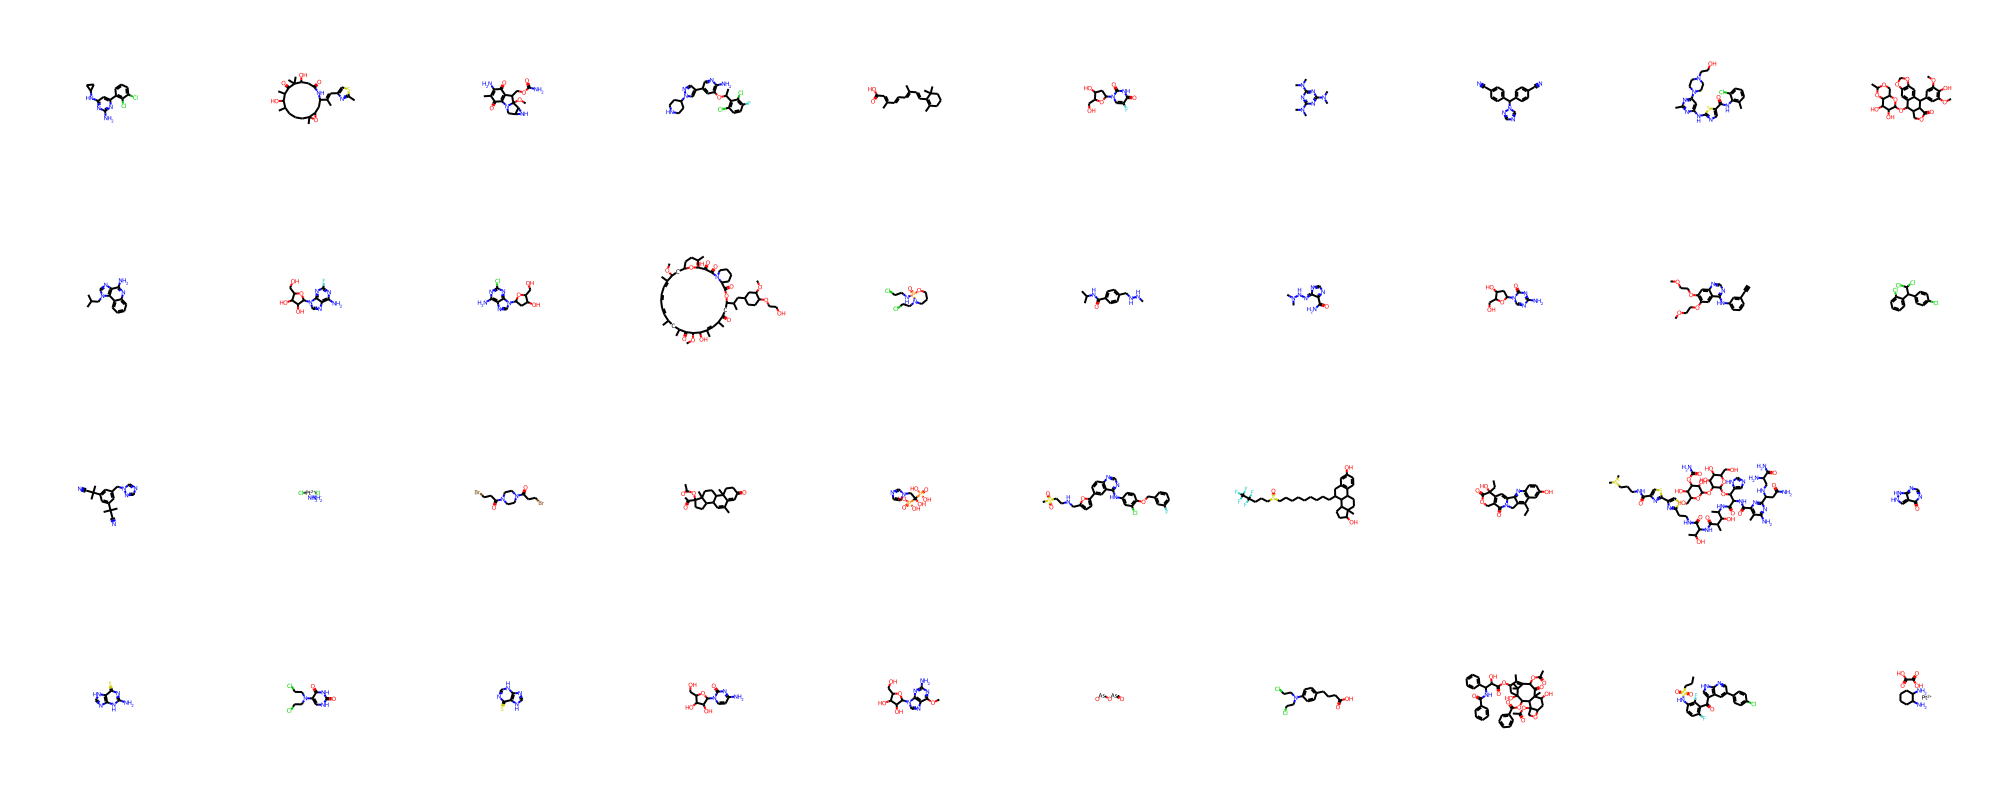

In [108]:
Draw.MolsToGridImage(uniq_mol.Mol.head(40), molsPerRow=10)

In [109]:
# num_drugs = len(uniq_mol)
# int((num_drugs * (num_drugs-1))/2)

In [110]:
# uniq_mol.iloc[0].Data

In [111]:
uniq_mol.iloc[0].DataOGB

Data(edge_index=[2, 42], edge_attr=[42, 3], x=[19, 9])

In [112]:
# zhang_labels = pd.read_csv(rawdata_dir + '/DS1/drug_drug_matrix_wids.csv').set_index('Unnamed: 0')
# y_df = zhang_labels

In [113]:
# %%time

# y_df = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'y_df.pkl'),
#                                      data_gen_fun = generate_labels_df,
#                                      data_gen_params=(uniq_mol, datashort))

In [114]:
# y_df = generate_labels_df(uniq_mol, data)

# ReaderWriter.dump_data(y_df, os.path.join(targetdata_dir_raw, 'y_df.pkl'))

#y_df = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'y_df.pkl'))

In [115]:
# y_df

In [116]:
# y_df[y_df > 0] = 1
# y_df

In [117]:
# y = get_y_from_interactionmat(y_df.to_numpy())
# len(y)

In [118]:
# binary_Y_threshold = 30

In [119]:
y = data.Y.copy()
y

0         1
1         1
2         1
3         1
4         1
         ..
195077    0
195078    0
195079    0
195080    0
195081    0
Name: Y, Length: 195082, dtype: int64

In [120]:
# str(round((len(y[y>=binary_Y_threshold]) / len(y) *100), 2)) + "% positive labels"

In [121]:
# sns.boxplot(y)

In [122]:
# positive_labels = y>=binary_Y_threshold
# negative_labels = y<binary_Y_threshold

In [123]:
# y[positive_labels] = 1
# y[negative_labels] = 0
# y = y.astype(int)
# y

In [124]:
y.values

array([1, 1, 1, ..., 0, 0, 0])

In [125]:
ReaderWriter.dump_data(y.values, os.path.join(targetdata_dir_raw, 'y.pkl'))

In [126]:
y_weights = compute_class_weights(torch.tensor(y))
y_weights

array([1.03029375, 0.97143682])

In [127]:
ReaderWriter.dump_data(y_weights, os.path.join(targetdata_dir_raw, 'y_weights.pkl'))

In [132]:
expression = np.array([df_rma_landm['DATA.'+ str(c)].values for c in data["Cosmic_ID"]])
expression.shape

(195082, 972)

In [133]:
ReaderWriter.dump_data(expression, os.path.join(targetdata_dir_raw, 'expression.pkl'))

In [134]:
# report_label_distrib(y)

In [135]:
# lasso_input_dim = 2*tp["emb_dim"]+1+expression_input_size
# lasso_out_dim = dataset.num_classes

# lassonet_model = LassoNet(lasso_input_dim, lasso_out_dim)# # pairs = list(itertools.combinations(uniq_mol.Drug_ID, 2))
# pairs = construct_sampleid_ddipairs(y_df.to_numpy())
# len(pairs)

In [136]:
pairs = {i:(row.Drug1_ID, row.Drug2_ID) for i, row in data.iterrows()}
len(pairs)

195082

In [137]:
# pairs

In [138]:
# pairs_sub = {k: pairs[k] for k in range(10)}
# pairs_sub

In [139]:
%%time

X = ReaderWriter.read_or_dump_data(file_name=norm_join_paths(targetdata_dir_raw, 'X.pkl'),
                              data_gen_fun=get_X_all_pairdata_synergy,
                              data_gen_params=(uniq_mol, pairs, "DataOGB"))

CPU times: user 5.48 s, sys: 849 ms, total: 6.33 s
Wall time: 6.31 s


In [140]:
# X = get_X_all_pairdata(uniq_mol, pairs)

# ReaderWriter.dump_data(X, os.path.join(targetdata_dir_raw, 'X.pkl'))

#X = ReaderWriter.read_data(os.path.join(targetdata_dir_raw, 'X.pkl'))


In [141]:
# X

In [142]:
targetdata_dir

'/cluster/home/skyriakos/chemprop_run/git/data/processed/SynergxZloewe/data_v1'

In [143]:
targetdata_dir_processed

'/cluster/home/skyriakos/chemprop_run/git/data/processed/SynergxZloewe/data_v1/processed'

In [144]:
# import glob

# list_generated_files = glob.glob(targetdata_dir_processed + "/*")
# print(list_generated_files)

# for file in list_generated_files:
#     os.remove(file)

In [ ]:
%%time

# In order to generate a new Dataset, first remove the generated files above

dataset = MoleculeDataset(root=targetdata_dir, dataset='tdcSynergy')

Processing...


In [ ]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data0 = dataset[0]  # Get the first graph object.

# print()
# print(data)
# print('=============================================================')

# # Gather some statistics about the first graph.
# print(f'Number of nodes: {data.num_nodes}')
# print(f'Number of edges: {data.num_edges}')
# print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
# print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
# print(f'Contains self-loops: {data.contains_self_loops()}')
# print(f'Is undirected: {data.is_undirected()}')

In [ ]:
data0

In [ ]:
data0.expression.dtype

In [ ]:
len(dataset)

### SynergxDB dataset

In [14]:
dataset_names = list(pd.read_csv('../data/synergxdb/datasets_hot_encoding.csv', header=None)[0])
dataset_names

['MERCK',
 'NCI-ALMANAC',
 'YALE-PDAC',
 'YALE-TNBC',
 'CLOUD',
 'MIT-MELANOMA',
 'STANFORD',
 'DECREASE',
 'VISAGE']

In [15]:
df_drug_comb = pd.read_csv('../data/synergxdb/drug_combinations_all.txt', sep='\t')
df_drug_comb

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,dataSet
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,[1. 0. 0. 0. 0. 0. 0. 0. 0.]
...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,[0. 0. 0. 0. 0. 0. 0. 0. 1.]
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [16]:
df_drug_comb['dsVec'] = [ast.literal_eval(ds.replace(" ", ',')) for ds in df_drug_comb['dataSet']]
df_drug_comb

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,dataSet,dsVec
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,[1. 0. 0. 0. 0. 0. 0. 0. 0.],"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,[0. 0. 0. 0. 0. 0. 0. 0. 1.],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [17]:
df_drug_comb.columns

Index(['smilesDrugA', 'smilesDrugB', 'idSample', 'bliss', 'loewe', 'dataSet',
       'dsVec'],
      dtype='object')

In [18]:
datasets_1hot = pd.DataFrame(data=np.stack(df_drug_comb['dsVec']), columns=dataset_names)
datasets_1hot

,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
531974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
df_drug_comb_1hot = pd.concat([df_drug_comb[['smilesDrugA', 'smilesDrugB', 'idSample', 'bliss', 'loewe']], datasets_1hot], axis=1)
df_drug_comb_1hot

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
df_drug_comb_1hot.to_csv('../data/synergxdb/drug_combinations_1hot_KS.tsv', sep='\t', index=False)

In [21]:
df_drug_comb_1hot[dataset_names].sum()

MERCK            22717.0
NCI-ALMANAC     296720.0
YALE-PDAC         3326.0
YALE-TNBC         4573.0
CLOUD             1327.0
MIT-MELANOMA    201254.0
STANFORD          1818.0
DECREASE           210.0
VISAGE              34.0
dtype: float64

In [22]:
df_drug_comb_1hot[dataset_names].sum(axis=1).value_counts()

1.0    531979
dtype: int64

In [23]:
melt = df_drug_comb_1hot[dataset_names].melt()
meltvar = melt[melt.value==1.0].variable
meltvar.index

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  7,       8,       9,
            ...
            4787801, 4787802, 4787803, 4787804, 4787805, 4787806, 4787807,
            4787808, 4787809, 4787810],
           dtype='int64', length=531979)

In [24]:
df_drug_comb_1hot['dsName'] = list(melt[melt.value==1.0].variable)
df_drug_comb_1hot

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE,dsName
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
531974,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,28,-0.5230,0.0025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531975,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,26,-0.5811,-0.0315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531976,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,23,-0.5919,-0.0446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE
531977,C1CC1NC2=NC(=NC(=C2)C3=C(C(=CC=C3)Cl)Cl)N,CCC1C(=O)N(C2=CN=C(N=C2N1C3CCCC3)NC4=C(C=C(C=C...,204,-0.5742,-0.3786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,VISAGE


In [25]:
len(set(df_drug_comb_1hot.idSample))

150

In [26]:
merck = df_drug_comb_1hot[df_drug_comb_1hot.MERCK == 1.0]
merck

,smilesDrugA,smilesDrugB,idSample,bliss,loewe,MERCK,NCI-ALMANAC,YALE-PDAC,YALE-TNBC,CLOUD,MIT-MELANOMA,STANFORD,DECREASE,VISAGE,dsName
0,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CC1=C(C(=O)C2=C(C1=O)N3CC4C(C3(C2COC(=O)N)OC)N4)N,25,-1.0773,-0.2243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
1,C1=CC=C(C=C1)NC(=O)CCCCCCC(=O)NO,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,37,-1.0052,-0.0900,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
2,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CCC1=C2CN3C(=CC4=C(C3=O)COC(=O)C4(CC)O)C2=NC5=...,80,-1.1420,-0.4718,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
3,COCCOC1=C(C=C2C(=C1)C(=NC=N2)NC3=CC=CC(=C3)C#C...,CC1(CCCN1)C2=NC3=C(C=CC=C3N2)C(=O)N,69,-0.7307,0.1504,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
4,C1CN(C(=O)CN1CC2=CN=CN2CC3=CC=C(C=C3)C#N)C4=CC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,85,-0.9707,-0.0021,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22712,CC12CCC3C(C1CCC2NC(=O)OCC(F)(F)F)CCC4C3(C=CC(=...,CN(C)C(=N)N=C(N)N,59,-0.0736,0.0682,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22713,C1CC(CCC1OC2=C(C(=CC=C2)Cl)F)(CC3=NC(=CC=C3)NC...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,25,-0.5037,0.2095,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22714,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,C1CC(CNC1)C2=CC=C(C=C2)N3C=C4C=CC=C(C4=N3)C(=O)N,80,-0.3817,0.3014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK
22715,CC(C)(C#N)C1=CC=C(C=C1)N2C3=C4C=C(C=CC4=NC=C3N...,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,28,-0.6611,-0.0184,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MERCK


<AxesSubplot:xlabel='loewe', ylabel='Count'>

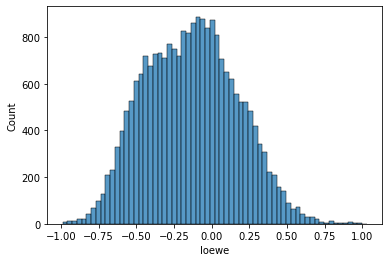

In [27]:
sns.histplot(merck.loewe)

<AxesSubplot:xlabel='bliss', ylabel='Count'>

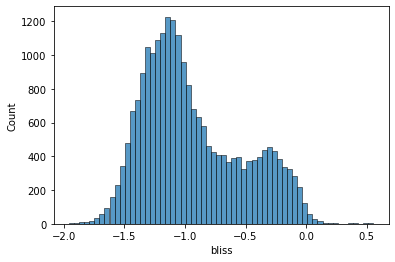

In [28]:
sns.histplot(merck.bliss)

(-2.0, 2.0)

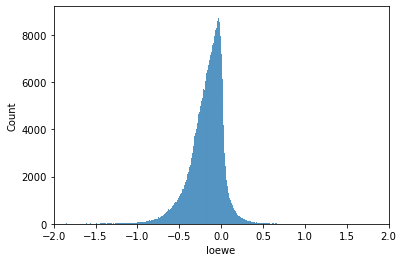

In [29]:
ax = sns.histplot(df_drug_comb_1hot.loewe)
ax.set_xlim(-2, 2)

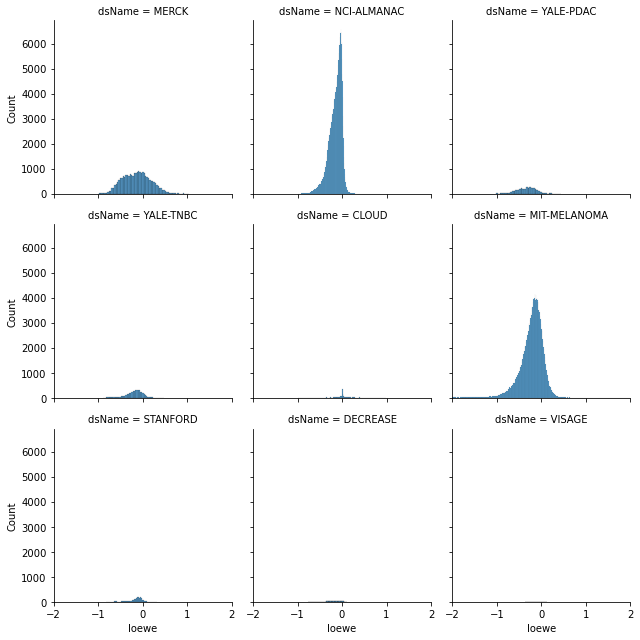

In [30]:
g = sns.FacetGrid(df_drug_comb_1hot, col="dsName", col_wrap=3, xlim=(-2, 2))
g.map(sns.histplot, "loewe")

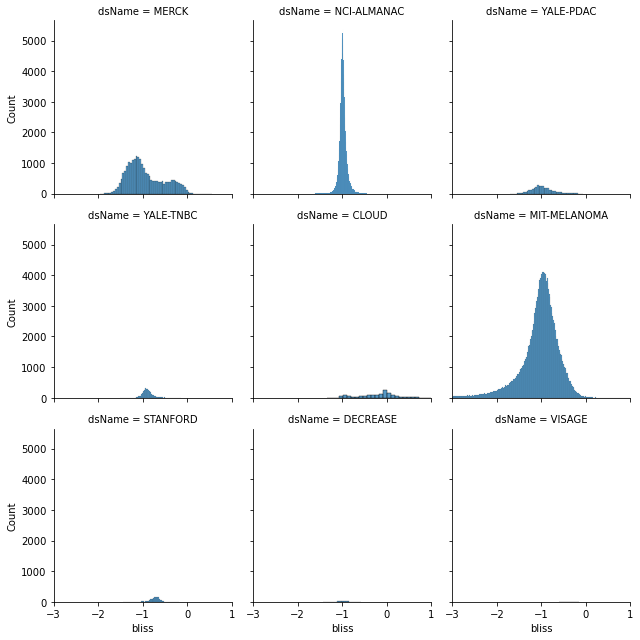

In [31]:
g = sns.FacetGrid(df_drug_comb_1hot, col="dsName", col_wrap=3, xlim=(-3, 1))
g.map(sns.histplot, "bliss")

In [32]:
set(df_drug_comb_1hot.idSample)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 94,
 96,
 116,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213}

In [33]:
df_mol_data_zscored = pd.read_csv('../data/synergxdb/molecular_data_zscored.csv')
df_mol_data_zscored

,Unnamed: 0,idSample,name,hgnc_symbol,fpkm,zscore
0,0,1,K-562,A1BG,0,-0.055465
1,1,1,K-562,A1BG-AS1,0,-0.055465
2,2,1,K-562,A1CF,0,-0.055465
3,3,1,K-562,A2M,0,-0.055465
4,4,1,K-562,A2M-AS1,0,-0.055465
...,...,...,...,...,...,...
3814123,3814123,186,T98G,ZYG11B,5,-0.019784
3814124,3814124,186,T98G,ZYX,48,0.287076
3814125,3814125,186,T98G,ZYXP1,0,-0.055465
3814126,3814126,186,T98G,ZZEF1,6,-0.012647


In [34]:
len(set(df_mol_data_zscored.name))

94

In [35]:
set(df_mol_data_zscored.idSample)

{1,
 2,
 3,
 4,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 37,
 38,
 39,
 40,
 41,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 82,
 83,
 84,
 85,
 86,
 87,
 89,
 90,
 94,
 96,
 116,
 156,
 157,
 159,
 163,
 164,
 166,
 167,
 168,
 169,
 170,
 173,
 174,
 177,
 178,
 186}

In [36]:
set(df_drug_comb_1hot.idSample).difference(set(df_mol_data_zscored.idSample))

{5,
 12,
 16,
 17,
 18,
 19,
 27,
 36,
 42,
 43,
 44,
 58,
 81,
 88,
 158,
 160,
 161,
 162,
 165,
 171,
 172,
 175,
 176,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 212,
 213}